<a href="https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyLatheDB - A Library for Relational Keyword Search with Support to Schema References
---

PyLatheDB is based on Lathe, an R-KwS framework that generalizes the well-known concepts of Query Matches (QMs) and Candidate Joining Networks (CJNs) to handle keywords referring to schema elements and introduces new algorithms to generate them, along with a novel approach to automatically select the CJNs that are more likely to represent the user intent when issuing a keyword query.

We recommend running this Python Notebook using [Google Colab](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb). But its static version is also available in our [GitHub Repository](https://github.com/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb).

## Environment Preparation

Initially, before the demonstration, it is necessary to  run an environment preparation step, which includes the installation of the RDBMS; the downloading of some configuration files and scripts; and the installation of the **PyLatheDB** library and its dependencies.

### Download of the configuration Files

The configuration files comprise information about the datasets and query sets used. They are automatically downloaded, but they can also be found [here](https://drive.google.com/drive/folders/1Xz3mPN0NC7xdIETKZlFDTcqcU6lsVUYD?usp=sharing).

In [1]:
!gdown --id 1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
!unzip PyLatheDB_DEMO_resources.zip
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('omw-1.4')

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1KTRL-RhKgnzENlwcGHZ7zkvT4fVsQ1D7
To: /content/PyLatheDB_DEMO_resources.zip
100% 92.3M/92.3M [00:03<00:00, 29.0MB/s]
Archive:  PyLatheDB_DEMO_resources.zip
   creating: config/
  inflating: config/config.json      
   creating: config/dataset_configs/
  inflating: config/dataset_configs/mondial.json  
   creating: config/dataset_configs/attributes/
  inflating: config/dataset_configs/attributes/imdb_filtered_attributes.json  
  inflating: config/dataset_configs/attributes/mondial_all_attributes.json  
  inflating: config/dataset_configs/attributes/mondial_filtered_attributes.json  
  inflating: config/dataset_configs/attributes/imdb_all_attributes.json  
  inflating: config/dataset_configs/imdb.json  
   creating: 

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Unzipping corpora/omw-1.4.zip.


True

### Installation of the PostgreSQL

In [2]:
# Install postgresql server
!sudo apt-get -y -qq update
!sudo apt-get -y -qq install postgresql postgresql-contrib &>log
!sudo service postgresql start

# Setup a password `postgres` for username `postgres`
!sudo -u postgres psql -U postgres -c "ALTER USER postgres PASSWORD 'postgres';"

!cp dbsources/pylathedb.stop /usr/share/postgresql/10/tsearch_data/english.stop

 * Starting PostgreSQL 10 database server
   ...done.
ALTER ROLE


### Scripts for the Databases Creation

In [3]:
!sudo -u postgres dropdb imdb &>>log
!sudo -u postgres createdb imdb &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-schema.pgsql &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-data.pgsql &>>log
!sudo -u postgres psql -U postgres imdb <  dbsources/imdb-fulltext_index.psql &>>log
!sudo -u postgres psql -U postgres imdb < dbsources/imdb-rename-tables.psql &>>log

!sudo -u postgres dropdb mondial &>>log
!sudo -u postgres createdb mondial &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part1.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-data.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-schema_part2.pgsql &>>log
!sudo -u postgres psql -U postgres mondial <  dbsources/mondial-field_fulltext_index.psql &>>log

### Enable DataTable Formating from Google Colab

In [4]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

### Installation of the PyLathe library available [here](https://pypi.org/project/pylathedb/)

In [5]:
# !pip install pylathedb==1.0.3 -U

!pip install -i https://test.pypi.org/simple/ pylathedb -U

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 51 kB 433 kB/s 
     |████████████████████████████████| 2.7 MB 8.2 MB/s 


## PyLatheDB setup

In this section, we will run the PyLatheDB setup, which comprises the creation of the Value Index and the Schema Index. We will also explain the main parameters of the library, such as number of QMs, number of CJNs per QM and the use of the eager evaluation strategy for CJN generation. 

### Library import and set configuration directory

In [6]:
from pylathedb.lathe import Lathe
lathe = Lathe(config_directory='./config/')

### Create Indexes 
This step is not necessary because we already downloaded the indexes alongside the configuration files. But feel free to test the Index Creation by uncommenting the following cell:

In [ ]:
# lathe.create_indexes()

### Load Indexes

The cell below shows how to load the Value and Schema Indexes.

In [7]:
lathe.load_indexes()

### Choose Query set/Database

You can choose which query set to use and its respective database. Input as a function parameter the number of the name of the query set to use. If you input no number, it will list the query sets available.

In [8]:
lathe.change_queryset()

Please input a query set to change:
01 - coffman_imdb
02 - coffman_mondial


In [9]:
lathe.change_queryset('coffman_imdb')

./config/queryset_configs/coffman_imdb_config.json
Changed to query set coffman_imdb.


### Default Parameters

We have a few parameters for R-KwS using PyLatheDB:
*    `max_qm_size`: Maximum Query Match Size
*    `max_cjn_size`: Maximum Candidate Joining Network Size
*    `topk_cns`: Top-k CJNs to be considered
*    `configuration`: A tuple containing the number of QMs to be considered, number of CJNs for each QM to be considered, and the maximum number of CJNs to be probed by the eager evaluation for each QM. 




In [10]:
lathe.max_qm_size = 3
lathe.max_cjn_size = 5
lathe.topk_cns = 10
lathe.configuration = (5,1,9)

## Keyword Search over Relational Databases

You can use the function `keyword_search` from the class `Lathe` using three parameters. 


1.   You can input a Keyword query
2.   You can call the function with no input to show a list of premade keyword queries used in Coffman Benchmark.
3.   You can input the number of the keyword query according to the option 2.

In [11]:
lathe.keyword_search()

Please input a keyword query or choose one of the queries below:
01 - denzel washington
02 - clint eastwood
03 - john wayne
04 - will smith
05 - harrison ford
06 - julia roberts
07 - tom hanks
08 - johnny depp
09 - angelina jolie
10 - morgan freeman
11 - gone with the wind
12 - star wars
13 - casablanca
14 - lord of the rings
15 - the sound of music
16 - wizard of oz
17 - the notebook
18 - forrest gump
19 - the princess bride
20 - the godfather
21 - title atticus finch
22 - title indiana jones
23 - title james bond
24 - title rick blaine
25 - title will kane
26 - title dr. hannibal lecter
27 - title norman bates
28 - title darth vader
29 - title the wicked witch of the west
30 - title nurse ratched
31 - title frankly my dear i don't give a damn
32 - title i'm going to make him an offer he can't refuse
33 - title you don't understand i coulda had class i coulda been a contender i coulda been somebody instead of a bum which is what i am
34 - title toto i've a feeling we're not in kansas 

### Understanding the Results

The function `keyword_search` from the class `Lathe` returns an `LatheResult` object, which contains methods to show the CJNs, QMs and KMs returned for the keyword query.

#### Candidate Joining Networks

The library returns, for each CJN, its Text representation, its Graph representation, its SQL translation and the returned results from the SQL execution by the RDBMS. The function `cjns` outputs the informatio about each CJN according to four boolean parameters: `text`, `graph`, `sql`, and `jnts`. All of them are enabled by default.


*The Graph representation may not be available in the static version of this notebook in Github. You can run it using Google Colab [here](https://colab.research.google.com/github/pr3martins/PyLatheDB/blob/main/demo/PyLatheDB_DEMO.ipynb).*

Keyword Query: julia roberts films


---

**1st CJN**:

---

Text:
	PERSON.v(name{roberts,julia})
		<CASTING
			>MOVIE.s(*{films})


---

Graph:


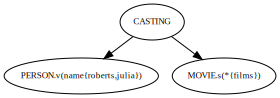

---

SQL:
  
  SELECT
  	t3.*,
  	t1.name
  FROM
  	"person" t1
  	JOIN "casting" t2 ON t2.person_id = t1.id
  	JOIN "movie" t3 ON t2.movie_id = t3.id
  WHERE
  	t1.name_tsvector @@ to_tsquery('roberts & julia')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,name
0,3161,20 Something,None,1,2006,None,S5352,None,None,None,None,43788412,"Roberts, Julia"
1,175564,Firehouse,None,1,1987,None,F62,None,None,None,None,43846816,"Roberts, Julia"
2,198621,Grand Champion,None,1,2002,None,G6532,None,None,None,None,43876968,"Roberts, Julia"
3,304918,Ljuset håller mig sällskap,None,1,2000,None,L2346,None,None,None,None,44099445,"Roberts, Julia"
4,422036,Runaway Bride,None,1,1999,None,R5163,None,None,None,None,44164278,"Roberts, Julia"


---

**2nd CJN**:

---

Text:
	MOVIE.s(*{films}).v(title{roberts,julia})


---

Graph:


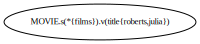

---

SQL:
  
  SELECT
  	t1.title,
  	t1.*
  FROM
  	"movie" t1
  WHERE
  	t1.title_tsvector @@ to_tsquery('roberts & julia')
  LIMIT 1000;



---

JNTs:


,title,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id
0,Untitled Julia Roberts/Joan Root Project,567842,Untitled Julia Roberts/Joan Root Project,None,1,2009,None,U5343,None,None,None,None,44309348


---

**3rd CJN**:

---

Text:
	MOVIEINFO.v(info{roberts,julia})
		>MOVIE.s(*{films})


---

Graph:


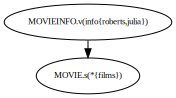

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	"movieinfo" t1
  	JOIN "movie" t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('roberts & julia')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,info
0,263267,Kiss the Bride,None,1,2007,None,K2316,None,None,None,None,43995987,Stephanie: You totally love him. You want to w...
1,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,[to Tess while she is pretending to be Julia R...
2,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,Tess Ocean: [while trying to get through a cro...
3,364762,Ocean's Twelve,None,1,2004,None,O2523,None,None,None,None,44054612,Tess Ocean: Ma Marcus?::Julia Roberts: Um... N...
4,523654,The Prestige,None,1,2006,None,P6232,None,None,None,None,44264635,Julia McCullough: I thought up a name for you:...


---

**4th CJN**:

---

Text:
	PERSON.v(name{julia})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{roberts})


---

Graph:


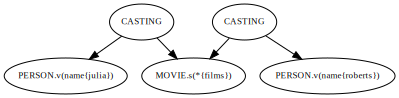

---

SQL:
  
  SELECT
  	t3.*,
  	t5.name,
  	t1.name
  FROM
  	"person" t1
  	JOIN "casting" t2 ON t2.person_id = t1.id
  	JOIN "movie" t3 ON t2.movie_id = t3.id
  	JOIN "casting" t4 ON t4.movie_id = t3.id
  	JOIN "person" t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('julia')
  	AND t5.name_tsvector @@ to_tsquery('roberts')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,name,name
0,387801,Pig Business,None,1,2009,None,P2125,None,None,None,None,44088144,"Kennedy Jr., Robert","Guest, Julia"
1,527311,The Rookie,None,1,1990,None,R2,None,None,None,None,44275854,"Harvey, Robert","Julia, Raul"
2,527311,The Rookie,None,1,1990,None,R2,None,None,None,None,44275854,"Dubac, Robert","Julia, Raul"
3,136518,Dispatch,None,1,2009,None,D2132,None,None,None,None,43911170,"Watzke, Robert","Boyd, Julia"
4,136518,Dispatch,None,1,2009,None,D2132,None,None,None,None,43911170,"Roberts, Arthur","Boyd, Julia"


---

**5th CJN**:

---

Text:
	PERSON.v(name{roberts,julia})
		<CASTING
			>CHARACTER
				<CASTING
					>MOVIE.v(title{films})


---

Graph:


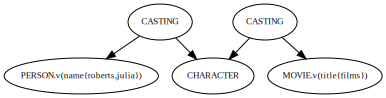

---

SQL:
  
  SELECT
  	t5.title,
  	t1.name
  FROM
  	"person" t1
  	JOIN "casting" t2 ON t2.person_id = t1.id
  	JOIN "character" t3 ON t2.person_role_id = t3.id
  	JOIN "casting" t4 ON t4.person_role_id = t3.id
  	JOIN "movie" t5 ON t4.movie_id = t5.id
  WHERE
  	t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('roberts & julia')
  	AND t5.title_tsvector @@ to_tsquery('films')
  LIMIT 1000;



---

JNTs:


,title,name
0,The Film That Was Lost,"Roberts, Julia"
1,The Fantasy Film Worlds of George Pal,"Roberts, Julia"
2,Going to Pieces: The Rise and Fall of the Slas...,"Roberts, Julia"
3,Going to Pieces: The Rise and Fall of the Slas...,"Roberts, Julia"
4,The Fantasy Film Worlds of George Pal,"Roberts, Julia"


In [12]:
result = lathe.keyword_search('julia roberts films')
result.cjns()

### Query Matches

The function `qms` returns a ranked list of the Query Matches for the keyword query. Each QM is presented as a set of Keyword Matches.

In [13]:
result.qms()

---

**1st QM**:

---

{PERSON.v(name{roberts,julia}), MOVIE.s(*{films})}


---

**2nd QM**:

---

{MOVIE.s(*{films}).v(title{roberts,julia})}


---

**3rd QM**:

---

{MOVIEINFO.v(info{roberts,julia}), MOVIE.s(*{films})}


---

**4th QM**:

---

{PERSON.v(name{julia}), PERSON.v(name{roberts}), MOVIE.s(*{films})}


---

**5th QM**:

---

{PERSON.v(name{roberts,julia}), MOVIE.v(title{films})}


### Keyword Matches

The function `kms` returns two unordered lists, one for the Schema-Keyword Matches and one for Value-Keyword Matches.

In [14]:
result.kms()

---

**SKMs**:

---

MOVIE.s(*{films})


---

**VKMs**:

---

MOVIEINFO.v(info{julia})
PERSON.v(name{julia})
CHARACTER.v(name{julia})
MOVIE.v(title{julia})
MOVIEINFO.v(info{roberts})
PERSON.v(name{roberts})
CHARACTER.v(name{roberts})
MOVIE.v(title{roberts})
MOVIEINFO.v(info{films})
CHARACTER.v(name{films})
MOVIE.v(title{films})
MOVIEINFO.v(info{roberts,julia})
MOVIEINFO.v(info{films,julia})
PERSON.v(name{roberts,julia})
MOVIE.v(title{roberts,julia})



### Example Queries


#### Keywords present in more than one keyword match

Keyword Query: john travolta olivia films


---

**1st CJN**:

---

Text:
	PERSON.v(name{travolta,john})
		<CASTING
			>MOVIE.s(*{films})
				<CASTING
					>PERSON.v(name{john,olivia})


---

Graph:


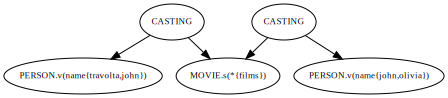

---

SQL:
  
  SELECT
  	t3.*,
  	t5.name,
  	t1.name
  FROM
  	"person" t1
  	JOIN "casting" t2 ON t2.person_id = t1.id
  	JOIN "movie" t3 ON t2.movie_id = t3.id
  	JOIN "casting" t4 ON t4.movie_id = t3.id
  	JOIN "person" t5 ON t4.person_id = t5.id
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('travolta & john')
  	AND t5.name_tsvector @@ to_tsquery('john & olivia')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,name,name
0,199214,Grease,None,1,1978,None,G62,None,None,None,None,43908386,"Newton-John, Olivia","Travolta, John"
1,559385,Two of a Kind,None,1,1983,None,T1253,None,None,None,None,44303665,"Newton-John, Olivia","Travolta, John"
2,504851,The Guru,None,1,2002,None,G6,None,None,None,None,44255543,"Newton-John, Olivia","Travolta, John"


---

**2nd CJN**:

---

Text:
	MOVIEINFO.v(info{travolta,john,olivia})
		>MOVIE.s(*{films})


---

Graph:


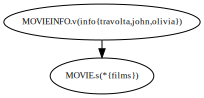

---

SQL:
  
  SELECT
  	t2.*,
  	t1.info
  FROM
  	"movieinfo" t1
  	JOIN "movie" t2 ON t1.movie_id = t2.id
  WHERE
  	t1.info_tsvector @@ to_tsquery('travolta & john & olivia')
  LIMIT 1000;



---

JNTs:


,id,title,imdb_index,kind_id,year,imdb_id,phonetic_code,episode_of_id,season_nr,episode_nr,series_years,__search_id,info
0,510494,The Last Days of Disco,None,1,1998,None,L2321,None,None,None,None,44283571,Josh Neff: Disco will never be over. It will a...


In [15]:
results = lathe.keyword_search('john travolta olivia films')
results.cjns()

#### Difficult queries which need eager evaluation

In [23]:
lathe.change_queryset(2)
lathe.load_indexes()

./config/queryset_configs/coffman_mondial_config.json
Changed to query set coffman_mondial.
Changed to dataset mondial.


Keyword Query: saint kitts cambodia


---

**1st CJN**:

---

Text:
	COUNTRY.v(name{kitts,saint})
		<IS_MEMBER
			>ORGANIZATION
				<IS_MEMBER
					>COUNTRY.v(name{cambodia})


---

Graph:


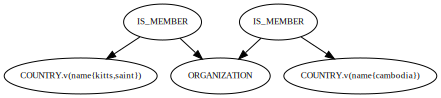

---

SQL:
  
  SELECT
  	t5.name,
  	t1.name
  FROM
  	"country" t1
  	JOIN "is_member" t2 ON t2.country = t1.code
  	JOIN "organization" t3 ON t2.organization = t3.abbreviation
  	JOIN "is_member" t4 ON t4.organization = t3.abbreviation
  	JOIN "country" t5 ON t4.country = t5.code
  WHERE
  	t1.ctid <> t5.ctid
  	AND t2.ctid <> t4.ctid
  	AND t1.name_tsvector @@ to_tsquery('kitts & saint')
  	AND t5.name_tsvector @@ to_tsquery('cambodia')
  LIMIT 1000;



---

JNTs:


,name,name
0,Cambodia,Saint Kitts and Nevis
1,Cambodia,Saint Kitts and Nevis
2,Cambodia,Saint Kitts and Nevis
3,Cambodia,Saint Kitts and Nevis
4,Cambodia,Saint Kitts and Nevis


In [28]:
results = lathe.keyword_search('saint kitts cambodia')
results.cjns(text=True,graph=True,sql=True,df=True)

#### Query whose relevant answer is not supported by other systems as they do not consider valid $R_a ← S_b → R_c$.

Keyword Query: slovakia hungary


---

**1st CJN**:

---

Text:
	COUNTRY.v(name{slovakia})
		<BORDERS
			>COUNTRY.v(name{hungary})


---

Graph:


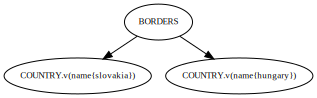

---

SQL:
  
  SELECT
  	t3.name,
  	t1.name
  FROM
  	"country" t1
  	JOIN "borders" t2 ON t2.country1 = t1.code
  	JOIN "country" t3 ON t2.country2 = t3.code
  WHERE
  	t1.ctid <> t3.ctid
  	AND t1.name_tsvector @@ to_tsquery('slovakia')
  	AND t3.name_tsvector @@ to_tsquery('hungary')
  LIMIT 1000;



---

JNTs:


,name,name
0,Hungary,Slovakia


In [29]:
results = lathe.keyword_search('slovakia hungary')
results.cjns()

### Running Benchmark



#### IMDb Dataset

In [ ]:
lathe.change_queryset(1)
lathe.load_indexes()

./config/queryset_configs/coffman_imdb_config.json
Changed to query set coffman_imdb.
Changed to dataset imdb.


In [ ]:
results = lathe.run_queryset()

Keyword Query: denzel washington
Keyword Query: clint eastwood
Keyword Query: john wayne
Keyword Query: will smith
Keyword Query: harrison ford
Keyword Query: julia roberts
Keyword Query: tom hanks
Keyword Query: johnny depp
Keyword Query: angelina jolie
Keyword Query: morgan freeman
Keyword Query: gone with the wind
Keyword Query: star wars
Keyword Query: casablanca
Keyword Query: lord of the rings
Keyword Query: the sound of music
Keyword Query: wizard of oz
Keyword Query: the notebook
Keyword Query: forrest gump
Keyword Query: the princess bride
Keyword Query: the godfather
Keyword Query: title atticus finch
Keyword Query: title indiana jones
Keyword Query: title james bond
Keyword Query: title rick blaine
Keyword Query: title will kane
Keyword Query: title dr. hannibal lecter
Keyword Query: title norman bates
Keyword Query: title darth vader
Keyword Query: title the wicked witch of the west
Keyword Query: title nurse ratched
Keyword Query: title frankly my dear i don't give a damn


In [ ]:
evaluation=lathe.evaluate_queryset(results)
evaluation.metrics()

,MRR,P@1,P@2,P@3,P@4,P@5,P@6,P@7,P@8,P@9,P@10
QMs,0.75,0.58,0.82,0.92,0.92,0.98,0.98,0.98,0.98,0.98,0.98
CJNs,0.78,0.64,0.82,0.94,0.96,0.98,0.98,0.98,0.98,0.98,0.98


In [ ]:
evaluation.relevant_positions()

Relevant Position    
                                        Keyword Query                QM CJN
1                                   denzel washington                 1   1
2                                      clint eastwood                 1   1
3                                          john wayne                 1   1
4                                          will smith                 1   1
5                                       harrison ford                 1   1
6                                       julia roberts                 1   1
7                                           tom hanks                 1   1
8                                         johnny depp                 3   3
9                                      angelina jolie                 1   1
10                                     morgan freeman                 1   1
11                                 gone with the wind                 1   1
12                                          star wars                 1   1
13                                         casablanca                 1   1
14                                  lord of the rings                 2   2
15                                 the sound of music                 1   1
16                                       wizard of oz                 1   1
17                                       the notebook                 1   1
18                                       forrest gump                 3   3
19                                 the princess bride                 1   1
20                                      the godfather                 1   1
21                                title atticus finch                 1   2
22                                title indiana jones                 2   2
23                                   title james bond                 2   3
24                                  title rick blaine                 2   2
25                                    title will kane                 3   3
26                          title dr. hannibal lecter                 1   1
27                                 title norman bates                 2   2
28                                  title darth vader                 3   4
29                 title the wicked witch of the west                 1   1
30                                title nurse ratched                 1   1
31          title frankly my dear i don't give a damn                 1   1
32  title i'm going to make him an offer he can't ...                 1   1
33  title you don't understand i coulda had class ...                -1  -1
34  title toto i've a feeling we're not in kansas ...                 1   1
35                    title here's looking at you kid                 1   1
36                                   hamill skywalker                 2   2
37                                         hanks 2004                 1   1
38              henry fonda yours mine ours character                 5   1
39                  russell crowe gladiator character                 2   1
40                             brent spiner star trek                 1   1
41                                audrey hepburn 1951                 1   1
42                              name jacques clouseau                 2   2
43                                     name jack ryan                 5   5
44                                     rocky stallone                 3   2
45                                    name terminator                 5   3
46                         harrison ford george lucas                 2   2
47                               sean connery fleming                 2   1
48                                   reeves wachowski                 1   1
49                                  dean jones herbie                 2   3
50                indiana jones last crusade lost ark                 2   1

#### MONDIAL Dataset

In [53]:
lathe.change_queryset(2)
lathe.load_indexes()

./config/queryset_configs/coffman_mondial_config.json
Changed to query set coffman_mondial.
Changed to dataset mondial.


In [ ]:
results = lathe.run_queryset()

Keyword Query: thailand
Keyword Query: netherlands
Keyword Query: georgia
Keyword Query: country china
Keyword Query: bangladesh
Keyword Query: alexandria
Keyword Query: sonsonate
Keyword Query: xiaogan
Keyword Query: city glendale
Keyword Query: city granada
Keyword Query: Lake Kariba
Keyword Query: Niger
Keyword Query: Arabian Sea
Keyword Query: Asauad
Keyword Query: Sardegna
Keyword Query: arab cooperation council
Keyword Query: world labor
Keyword Query: islamic conference
Keyword Query: 30 group
Keyword Query: caribbean economic
Keyword Query: slovakia hungary
Keyword Query: mongolia china
Keyword Query: niger algeria
Keyword Query: kuwait saudi arabia
Keyword Query: lebanon syria
Keyword Query: cameroon economy
Keyword Query: nigeria gdp
Keyword Query: mongolia republic
Keyword Query: kiribati politics
Keyword Query: poland language
Keyword Query: spain galician
Keyword Query: uzbekistan eastern orthodox
Keyword Query: haiti religion
Keyword Query: suriname ethnic_group
Keyword Q

In [ ]:
evaluation=lathe.evaluate_queryset(results)
evaluation.metrics()

,MRR,P@1,P@2,P@3,P@4,P@5,P@6,P@7,P@8,P@9,P@10
QMs,0.94,0.88,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
CJNs,0.95,0.94,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96,0.96


In [ ]:
evaluation.relevant_positions()

Relevant Position    
                               Keyword Query                QM CJN
1                                   thailand                 1   1
2                                netherlands                 1   1
3                                    georgia                 1   1
4                              country china                 2   1
5                                 bangladesh                 1   1
6                                 alexandria                 1   1
7                                  sonsonate                 1   1
8                                    xiaogan                 1   1
9                              city glendale                 1   1
10                              city granada                 1   1
11                               Lake Kariba                 1   1
12                                     Niger                 1   1
13                               Arabian Sea                 1   1
14                                    Asauad                 1   1
15                                  Sardegna                 1   1
16                  arab cooperation council                 1   1
17                               world labor                 1   1
18                        islamic conference                 1   1
19                                  30 group                 1  -1
20                        caribbean economic                 1   1
21                          slovakia hungary                 1   1
22                            mongolia china                 2   1
23                             niger algeria                 2   1
24                       kuwait saudi arabia                 1   1
25                             lebanon syria                 1   1
26                          cameroon economy                 1   1
27                               nigeria gdp                 1   1
28                         mongolia republic                 1   1
29                         kiribati politics                 1   1
30                           poland language                 1   1
31                            spain galician                 1   1
32               uzbekistan eastern orthodox                 1   1
33                            haiti religion                 1   1
34                     suriname ethnic_group                 1   1
35                           slovakia german                 2   1
36            poland cape verde organization                 1   1
37                      saint kitts cambodia                 1   1
38  marshall islands grenadines organization                 1   1
39  czech republic cote divoire organization                 1  -1
40                               panama oman                 1   1
41                              iceland mali                 1   1
42                       guyana sierra leone                 1   1
43                           mauritius india                 1   1
44                       vanuatu afghanistan                 1   1
45                           libya australia                 2   1
46                               hutu africa                 1   1
47                               serb europe                 1   1
48                                uzbek asia                 2   2
49                             rhein germany                 1   1
50                                egypt nile                 1   1

In [45]:
list(schema_graph.vertices())

['casting',
 'movie',
 'movieinfo',
 'person',
 'character',
 'role',
 'borders',
 'country',
 'city',
 'province',
 'economy',
 'encompasses',
 'continent',
 'ethnic_group',
 'geo_desert',
 'desert',
 'geo_island',
 'island',
 'geo_lake',
 'lake',
 'geo_mountain',
 'mountain',
 'geo_river',
 'river',
 'geo_sea',
 'sea',
 'is_member',
 'organization',
 'language',
 'located',
 'merges_with',
 'politics',
 'population',
 'religion']

In [47]:
schema_graph._graph_dict = {}
schema_graph._edges_info = {}

Graph:


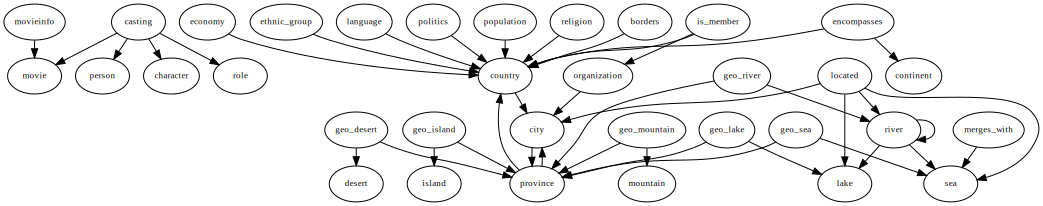

In [54]:
from graphviz import Digraph

schema_graph=lathe.index_handler.schema_graph

g= Digraph(
    graph_attr={'nodesep':'0.2','ranksep':'0.25'},
    node_attr={'fontsize':"9.0",},
    edge_attr={'arrowsize':'0.9',},
 )
for id in schema_graph.vertices():
    g.node(id)
for id_a,id_b in schema_graph.edges():
    g.edge(id_a,id_b)
# printmd('---')
print('Graph:')
display(g)